In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
seed = 2024
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cpu')  # Force CPU on Mac to avoid memory issues
print(f'Using device: {device}')

# Download data first (separate cell)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print("Downloading FashionMNIST (first run only)...")
trainval_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)
print("Download complete!")


Using device: cpu


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.4MB/s]

Download complete!


In [2]:
# Transform: Normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download FashionMNIST
trainval_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

# Split train/val (90/10)
train_size = int(0.9 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

# Dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Output: 32x28x28
            nn.ReLU(),
            nn.MaxPool2d(2),                            # 32x14x14
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64x14x14
            nn.ReLU(),
            nn.MaxPool2d(2),                            # 64x7x7
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = FashionCNN().to(device)
print(model)


FashionCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    train_loss /= train_total
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_loss /= val_total
    val_acc = val_correct / val_total

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1:2d}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")


Epoch  1: Train Loss=0.4459, Acc=0.8392, Val Loss=0.3260, Acc=0.8858
Epoch  2: Train Loss=0.2782, Acc=0.8999, Val Loss=0.2624, Acc=0.9095
Epoch  3: Train Loss=0.2349, Acc=0.9143, Val Loss=0.2553, Acc=0.9077
Epoch  4: Train Loss=0.2026, Acc=0.9251, Val Loss=0.2308, Acc=0.9197
Epoch  5: Train Loss=0.1782, Acc=0.9338, Val Loss=0.2504, Acc=0.9100
Epoch  6: Train Loss=0.1560, Acc=0.9420, Val Loss=0.2358, Acc=0.9135
Epoch  7: Train Loss=0.1354, Acc=0.9499, Val Loss=0.2412, Acc=0.9192
Epoch  8: Train Loss=0.1140, Acc=0.9576, Val Loss=0.2593, Acc=0.9183
Epoch  9: Train Loss=0.0985, Acc=0.9631, Val Loss=0.2497, Acc=0.9193
Epoch 10: Train Loss=0.0838, Acc=0.9695, Val Loss=0.2713, Acc=0.9160
Epoch 11: Train Loss=0.0725, Acc=0.9730, Val Loss=0.2814, Acc=0.9175
Epoch 12: Train Loss=0.0603, Acc=0.9779, Val Loss=0.3031, Acc=0.9202
Epoch 13: Train Loss=0.0515, Acc=0.9804, Val Loss=0.3390, Acc=0.9147
Epoch 14: Train Loss=0.0455, Acc=0.9832, Val Loss=0.3381, Acc=0.9188
Epoch 15: Train Loss=0.0430, Acc=0

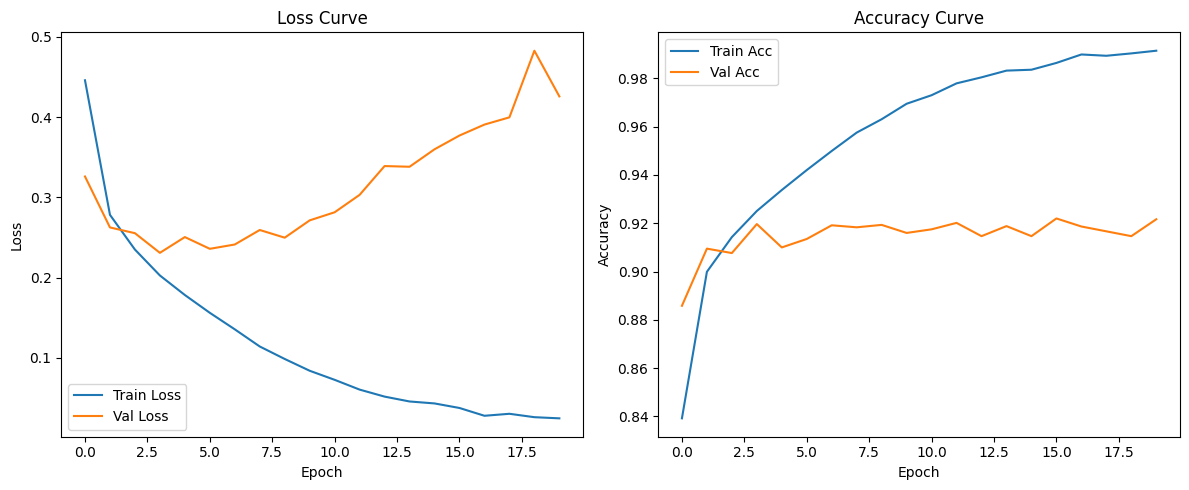

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()


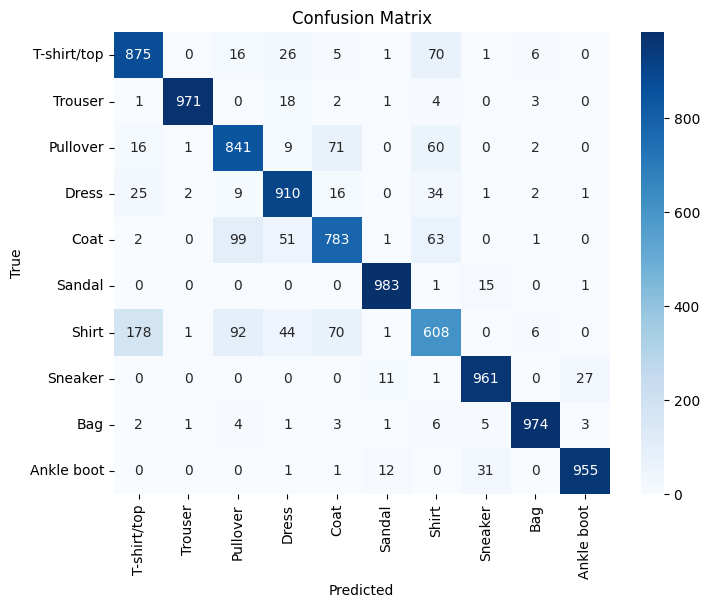

         Class  Accuracy
0  T-shirt/top     0.875
1      Trouser     0.971
2     Pullover     0.841
3        Dress     0.910
4         Coat     0.783
5       Sandal     0.983
6        Shirt     0.608
7      Sneaker     0.961
8          Bag     0.974
9   Ankle boot     0.955


In [8]:
# Class labels
classes = trainval_dataset.dataset.classes if hasattr(trainval_dataset, 'dataset') else trainval_dataset.classes

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
acc_df = pd.DataFrame({'Class':classes, 'Accuracy':per_class_acc})
print(acc_df)


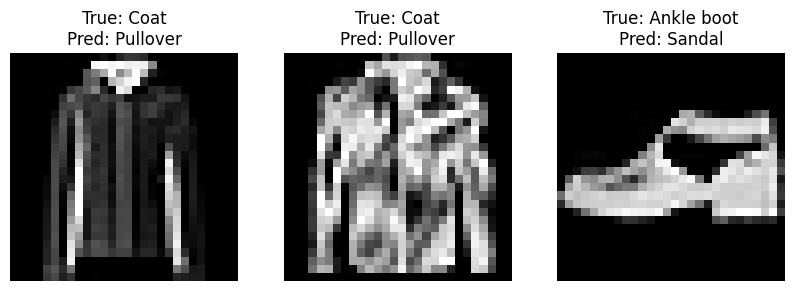

In [9]:
mis_idx = np.where(all_preds != all_labels)[0][:3]
mis_imgs = [test_dataset[i][0] for i in mis_idx]
mis_labels = [all_labels[i] for i in mis_idx]
mis_preds = [all_preds[i] for i in mis_idx]

fig, axes = plt.subplots(1, 3, figsize=(10,4))
for i, ax in enumerate(axes):
    ax.imshow(mis_imgs[i][0], cmap='gray')
    ax.set_title(f"True: {classes[mis_labels[i]]}\nPred: {classes[mis_preds[i]]}")
    ax.axis('off')
plt.show()


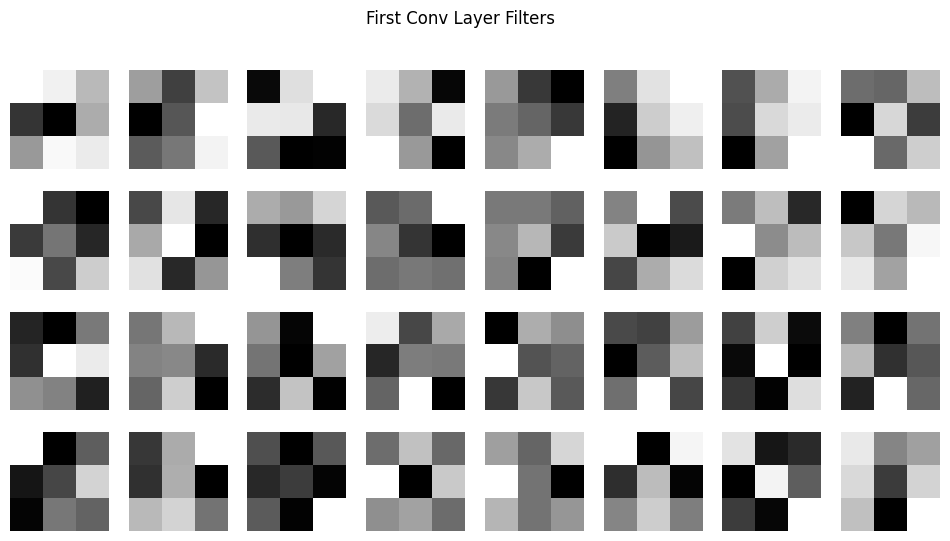

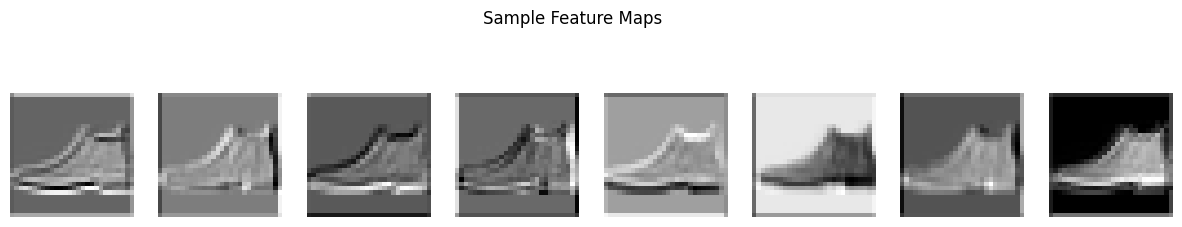

In [10]:
# Visualize first conv layer filters
weights = model.features[0].weight.data.clone().cpu()
fig, axes = plt.subplots(4, 8, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(weights[i,0], cmap='gray')
    ax.axis('off')
plt.suptitle('First Conv Layer Filters')
plt.show()

# Visualize feature maps from one test image
example_img,_ = test_dataset[0]
with torch.no_grad():
    x = example_img.unsqueeze(0).to(device)
    fmap = model.features[0](x)
fmap = fmap.squeeze().cpu()

plt.figure(figsize=(15,3))
for i in range(8): # visualize first 8 feature maps
    plt.subplot(1,8,i+1)
    plt.imshow(fmap[i], cmap='gray')
    plt.axis('off')
plt.suptitle('Sample Feature Maps')
plt.show()


In [11]:
# Results summary table
final_results = {
    "Train Acc": train_acc_hist[-1],
    "Val Acc": val_acc_hist[-1],
    "Test Acc": accuracy_score(all_labels, all_preds)
}
summary_table = pd.DataFrame([final_results])
print("Summary Table:\n", summary_table)

# Log Hyperparameters and Seed
print(f"Random seed: {seed}, Learning rate: {optimizer.param_groups[0]['lr']}, Batch size: {batch_size}, Model: {model}")


Summary Table:
    Train Acc   Val Acc  Test Acc
0   0.941889  0.888667    0.8861
Random seed: 2024, Learning rate: 0.01, Batch size: 64, Model: FashionCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 20

train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
    train_loss /= train_total
    train_acc = train_correct / train_total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_loss /= val_total
    val_acc = val_correct / val_total

    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    print(f"Epoch {epoch+1:2d}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")


Epoch  1: Train Loss=0.3138, Acc=0.8901, Val Loss=0.3419, Acc=0.8833
Epoch  2: Train Loss=0.2876, Acc=0.8972, Val Loss=0.3301, Acc=0.8917
Epoch  3: Train Loss=0.2700, Acc=0.9031, Val Loss=0.3127, Acc=0.8888
Epoch  4: Train Loss=0.2496, Acc=0.9094, Val Loss=0.3317, Acc=0.8958
Epoch  5: Train Loss=0.2426, Acc=0.9129, Val Loss=0.3264, Acc=0.8877
Epoch  6: Train Loss=0.2263, Acc=0.9197, Val Loss=0.3393, Acc=0.8943
Epoch  7: Train Loss=0.2266, Acc=0.9189, Val Loss=0.3313, Acc=0.8948
Epoch  8: Train Loss=0.2206, Acc=0.9214, Val Loss=0.3866, Acc=0.8883
Epoch  9: Train Loss=0.2208, Acc=0.9236, Val Loss=0.4220, Acc=0.8860
Epoch 10: Train Loss=0.2073, Acc=0.9271, Val Loss=0.4220, Acc=0.8790
Epoch 11: Train Loss=0.2111, Acc=0.9284, Val Loss=0.4233, Acc=0.8935
Epoch 12: Train Loss=0.1952, Acc=0.9330, Val Loss=0.4287, Acc=0.8925
Epoch 13: Train Loss=0.2038, Acc=0.9315, Val Loss=0.4318, Acc=0.8900
Epoch 14: Train Loss=0.1976, Acc=0.9321, Val Loss=0.4704, Acc=0.8982
Epoch 15: Train Loss=0.1767, Acc=0

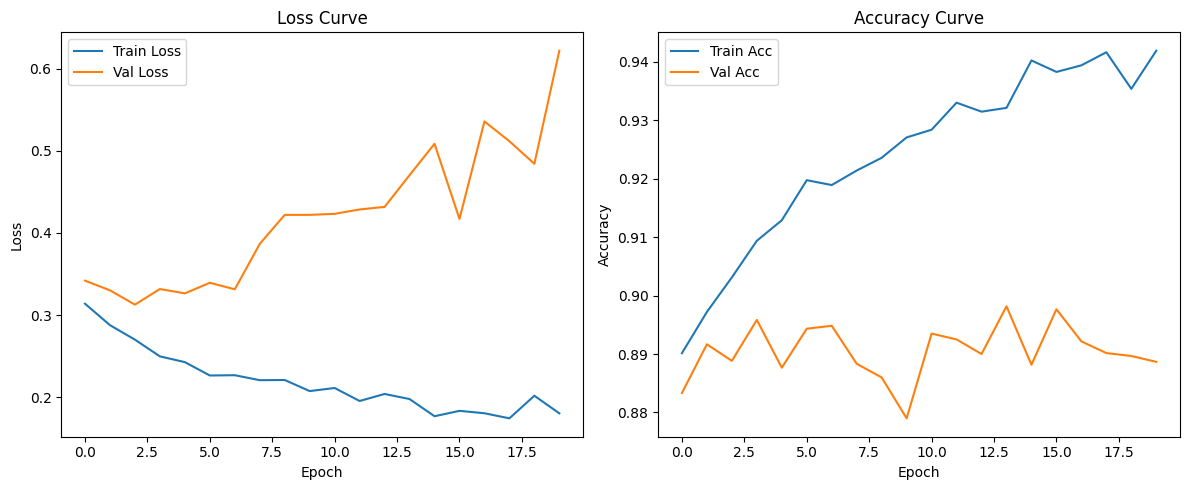

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.tight_layout()
plt.show()


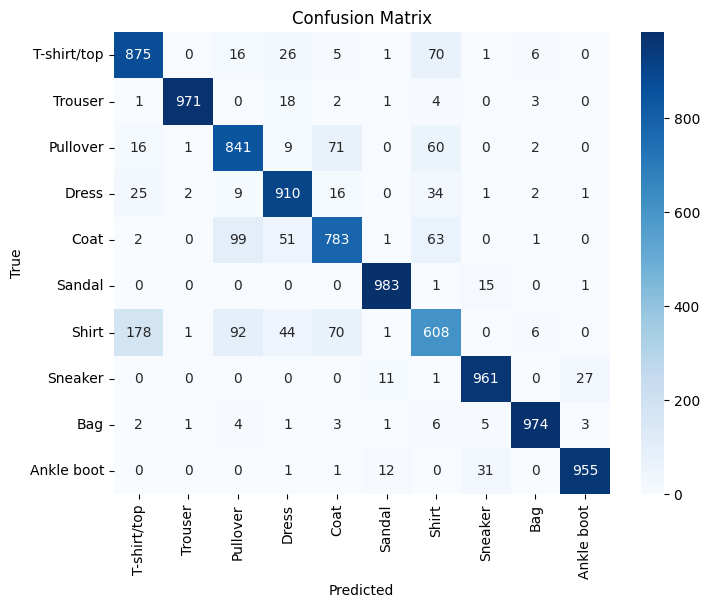

         Class  Accuracy
0  T-shirt/top     0.875
1      Trouser     0.971
2     Pullover     0.841
3        Dress     0.910
4         Coat     0.783
5       Sandal     0.983
6        Shirt     0.608
7      Sneaker     0.961
8          Bag     0.974
9   Ankle boot     0.955


In [12]:
# Class labels
classes = trainval_dataset.dataset.classes if hasattr(trainval_dataset, 'dataset') else trainval_dataset.classes

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
acc_df = pd.DataFrame({'Class':classes, 'Accuracy':per_class_acc})
print(acc_df)

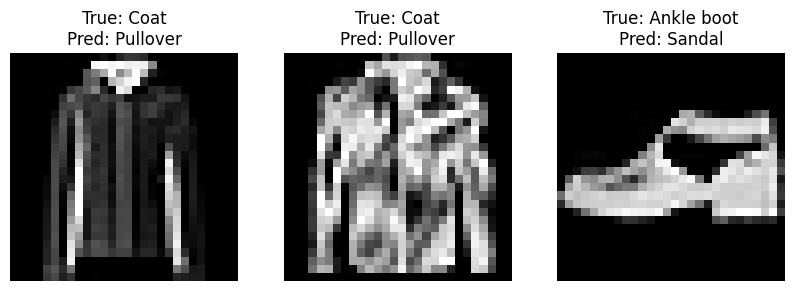

In [13]:
mis_idx = np.where(all_preds != all_labels)[0][:3]
mis_imgs = [test_dataset[i][0] for i in mis_idx]
mis_labels = [all_labels[i] for i in mis_idx]
mis_preds = [all_preds[i] for i in mis_idx]

fig, axes = plt.subplots(1, 3, figsize=(10,4))
for i, ax in enumerate(axes):
    ax.imshow(mis_imgs[i][0], cmap='gray')
    ax.set_title(f"True: {classes[mis_labels[i]]}\nPred: {classes[mis_preds[i]]}")
    ax.axis('off')
plt.show()

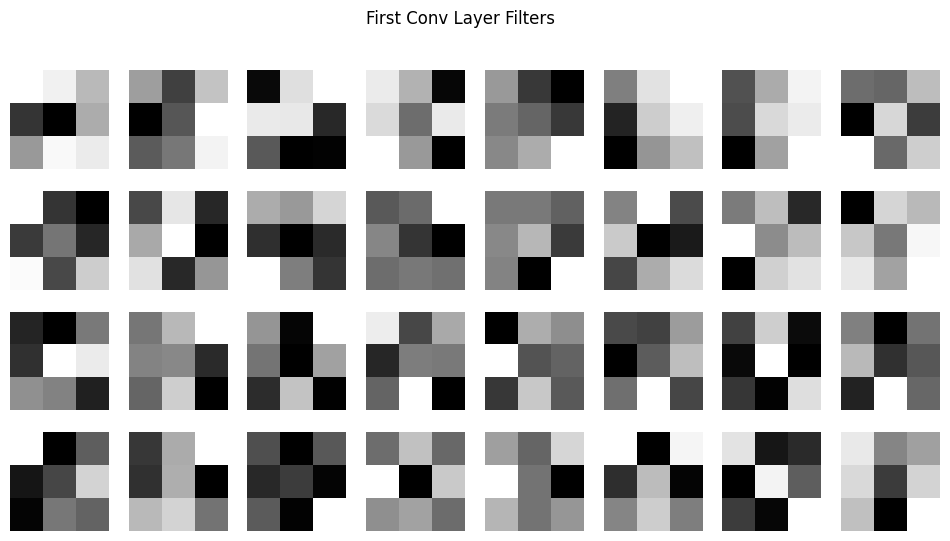

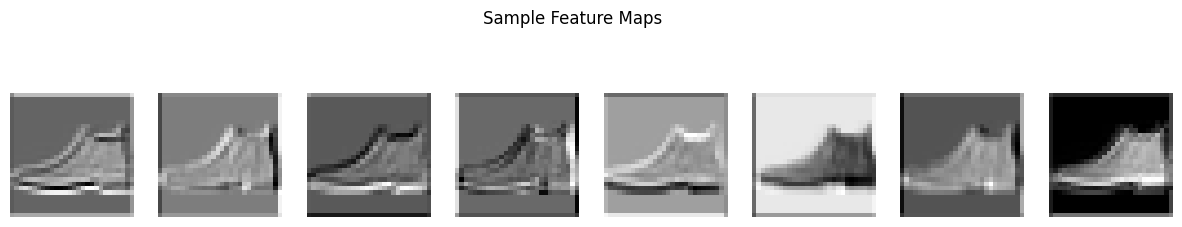

In [14]:
# Visualize first conv layer filters
weights = model.features[0].weight.data.clone().cpu()
fig, axes = plt.subplots(4, 8, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(weights[i,0], cmap='gray')
    ax.axis('off')
plt.suptitle('First Conv Layer Filters')
plt.show()

# Visualize feature maps from one test image
example_img,_ = test_dataset[0]
with torch.no_grad():
    x = example_img.unsqueeze(0).to(device)
    fmap = model.features[0](x)
fmap = fmap.squeeze().cpu()

plt.figure(figsize=(15,3))
for i in range(8): # visualize first 8 feature maps
    plt.subplot(1,8,i+1)
    plt.imshow(fmap[i], cmap='gray')
    plt.axis('off')
plt.suptitle('Sample Feature Maps')
plt.show()

In [15]:
# Results summary table
final_results = {
    "Train Acc": train_acc_hist[-1],
    "Val Acc": val_acc_hist[-1],
    "Test Acc": accuracy_score(all_labels, all_preds)
}
summary_table = pd.DataFrame([final_results])
print("Summary Table:\n", summary_table)

# Log Hyperparameters and Seed
print(f"Random seed: {seed}, Learning rate: {optimizer.param_groups[0]['lr']}, Batch size: {batch_size}, Model: {model}")


Summary Table:
    Train Acc   Val Acc  Test Acc
0   0.941889  0.888667    0.8861
Random seed: 2024, Learning rate: 0.01, Batch size: 64, Model: FashionCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
